# Bayesian survival analysis with LFP

We fit a Stan model for survival analysis (event time = stop time) using trial type and LFP power as covariates. This notebook examines the results.

In [1]:
import numpy as np
import pandas as pd
import pystan
import pickle
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
dtup = 18, 1

In [3]:
fname = '.'.join([str(x) for x in dtup]) 

In [4]:
dat = pd.read_csv('data/' + fname + '.lfpsurvdata.csv', index_col=0)
dat.shape

(2755, 163)

### Take an average across trials

In [5]:
aa = dat.set_index('rel_time').iloc[:, 2:]
aa.head()

,delta.17,delta.18,delta.19,delta.20,delta.21,delta.22,delta.23,delta.24,delta.25,delta.26,...,gamma.39,gamma.40,gamma.41,gamma.42,gamma.43,gamma.44,gamma.45,gamma.46,gamma.47,gamma.48
rel_time,,,,,,,,,,,,,,,,,,,,,
0.005,-0.735178,-1.330863,-0.710974,0.308978,-0.578644,-0.271552,-0.523623,-0.523699,-0.556466,-0.713439,...,-0.082706,-0.288317,-0.032530,-0.632237,-0.764288,-0.027949,-0.429730,-0.236582,-0.409046,-0.590530
0.105,-0.809913,-1.574337,-0.950896,0.196522,-0.570227,-0.297792,-0.520352,-0.507929,-0.564403,-0.480528,...,-0.121087,-0.185387,-0.031908,-0.728103,-0.718759,0.016201,-0.462355,-0.239823,-0.438638,-0.673115
0.205,-0.683875,-1.289722,-0.671301,0.196758,-0.365199,-0.112969,-0.447046,-0.461669,-0.581679,-0.137450,...,-0.267067,-0.194236,-0.006270,-0.872138,-0.587046,0.135395,-0.457273,-0.119727,-0.306135,-0.727477
0.305,-0.483485,-0.917769,-0.228707,0.283276,-0.036796,0.095637,-0.372691,-0.429403,-0.557724,-0.049794,...,-0.407923,-0.216595,-0.050053,-0.894240,-0.567759,0.183045,-0.426898,0.018055,-0.279995,-0.585856
0.405,-0.400064,-0.730907,-0.071031,0.513303,0.152952,0.083682,-0.380637,-0.428890,-0.469633,-0.076130,...,-0.505727,-0.210713,-0.222199,-0.855562,-0.492798,0.130939,-0.425072,0.176768,-0.302899,-0.446333


<IPython.core.display.Javascript object>


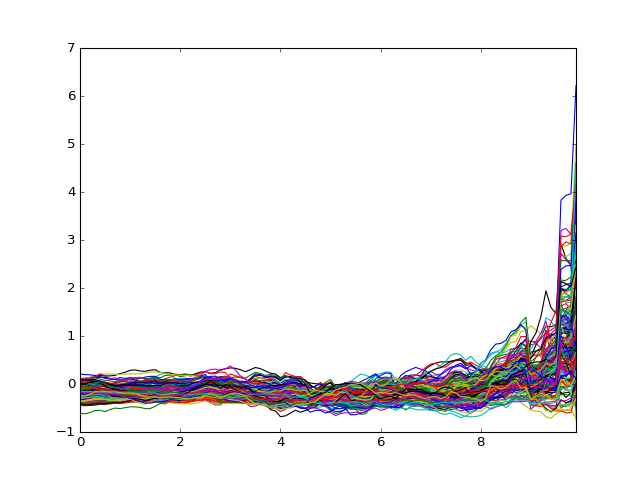

In [6]:
bb = dat.drop(['event', 'ttype'], axis=1).set_index('rel_time')
mn = bb.groupby(by=lambda x: np.around(x, decimals=1)).mean()
ss = bb.groupby(by=lambda x: np.around(x, decimals=1)).std()
(mn).plot(legend=False)
# plt.ylim(-1, 1);

In [7]:
with open('data/' + fname + '.stan_model', 'rb') as f:
    sm = pickle.load(f)
with open('data/' + fname + '.stan_samples', 'rb') as f:
    fit = pickle.load(f)

In [8]:
def get_summ_df(fit, var):
    summ = fit.summary(var)
    return pd.DataFrame(summ['summary'], index=summ['summary_rownames'], columns=summ['summary_colnames'])

In [9]:
betas = get_summ_df(fit, 'beta')

In [10]:
betas

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[0],-0.009395,0.001403,0.038357,-0.109624,-0.023080,-0.001706,0.007493,0.062215,747.0,1.002283
beta[1],-0.026395,0.001878,0.052375,-0.151339,-0.049148,-0.009014,0.002519,0.061738,778.0,1.002452
beta[2],-0.034471,0.002577,0.072244,-0.243670,-0.059029,-0.007207,0.002523,0.059793,786.0,0.995933
beta[3],0.005138,0.001999,0.050097,-0.102847,-0.011671,0.000196,0.017453,0.133866,628.0,1.000149


In [15]:
def plot_coeffs(df, sorted=False, transform=None):
    fig = plt.figure()
    if transform:
        b_m = transform(df['mean'])
        b_lo = b_m - transform(df['2.5%'])
        b_hi = transform(df['97.5%']) - b_m
    else:
        b_m = df['mean']
        b_lo = b_m - df['2.5%']
        b_hi = df['97.5%'] - b_m

    if len(b_m) > 1:
        if sorted:
            idx = np.argsort(b_m)
        else:
            idx = np.arange(len(b_m))

        b_m, b_lo, b_hi = b_m[idx], b_lo[idx], b_hi[idx]

        contains_1 = (df['2.5%'][idx] < 0) & (df['97.5%'][idx] > 0)
        
    else:
        contains_1 = (df['2.5%'] < 0) & (df['97.5%'] > 0)
    
    plt.errorbar(np.arange(len(b_m)), b_m, yerr=[b_lo, b_hi], capthick=0, 
                 marker='o', linestyle='None')

    # plot "significant" coefficients in red
    
    sigs = np.where(~contains_1)[0]
    plt.errorbar(sigs, b_m[sigs], yerr=[b_lo[sigs], b_hi[sigs]], capthick=0, 
                 marker='o', linestyle='None', color='red')

    plt.axhline(1., color='k', zorder=-1)
    plt.xlim(-1, len(b_m) + 1)
    
    return fig

<IPython.core.display.Javascript object>


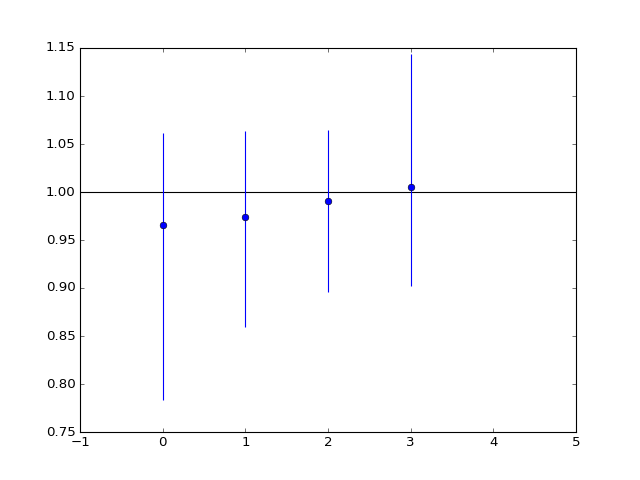

In [16]:
plot_coeffs(betas, sorted=True, transform=np.exp);

In [13]:
haz_means = get_summ_df(fit, 'mm')
haz_means.head()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mm[0],6.560896,0.064018,1.415650,4.006079,5.636679,6.448605,7.330114,9.775378,489.0,1.005558
mm[1],4.165651,0.022261,0.491268,3.365366,3.810629,4.114108,4.444084,5.255759,487.0,1.005937
mm[2],2.867666,0.018811,0.417672,2.186551,2.560400,2.811947,3.112916,3.823677,493.0,1.002154


<IPython.core.display.Javascript object>


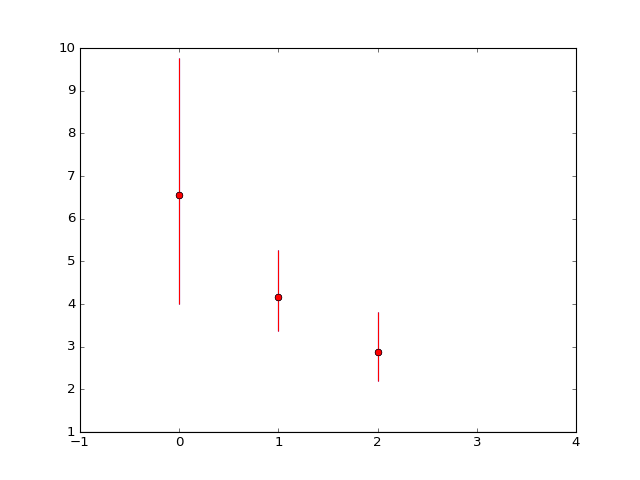

In [14]:
plot_coeffs(haz_means);